In [17]:
%config ZMQInteractiveShell.ast_node_interactivity = "all"
%pprint

Pretty printing has been turned OFF


## BN原理

- `ICS(Internal Covariate Shift)`：因为每一层参数变化导致每一层输入分布发生变化，导致网络学习困难（需要更小的学习率以及更仔细的初始化，还存在饱和区域造成梯度消失的问题）
- `BN（Batch Normalization）`的提出就是为了减少ICS，使得网络可以更好的学习，同时起到加速训练的作用（原始论文），后来MIT的一篇2018年的论文通过四个对比实验说明了，BN的work跟ICS没啥关系，甚至可能会增大ICS；BN work的根本原因是使得优化地形更加平滑，而且其他的一些normalization技术也有类似的效果，有些甚至比BN还好
- `BN`使用对mini-batch简单归一化和线性变换来克服白化的缺点（计算量大，存在不可导，改变网络层本身的表达能力）
- 训练的时候：
    - $\mu_{\beta} = \frac{1}{m}\sum_{i=1}^m x_i$
    - $\sigma_{\beta} = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\beta})^2$
    - $x_i = \frac{x_i - \mu_{\beta}}{\sigma_{\beta}}$
    - $y_i = \gamma \hat x_i + \beta$，可学习的拉伸和偏移参数保留了不对$\hat x_i$做批量归一化的可能，此时只需要学到$\gamma \sqrt{\sigma_{\beta}^2 + \epsilon}$和$\beta=\mu_{\beta}$
- 推理的时候：
    - $E(x) = E_{\beta}[\mu_{\beta}], var(x) = \frac{m}{m-1}E_{\beta}[{\sigma^2_{\beta}}$]
- 由于BN和Dropout之间存在方差偏移，所以在同时使用Dropout和BN时，在推理过程中可能存在问题
    - 要不将Dropout放在所有的BN之后
    - 要不修改Dropout的公式
- 在训练的时候，batch_size不能设置太小，在测试的时候，理论上可以使用全部训练数据的方差和均值来计算，但是一般不能放所有的训练数据，因此一般采取移动平均来进行计算（在训练模式和测试模式下的训练结果是不一样的）
- 另外BN在计算全连接层和CNN层是有区别的，一般不用在RNN，因为RNN的输入序列长度不一样，造成方差和均值的统计困难

## BN的实现

### BN的全连接层验证

In [100]:
a = torch.arange(12.).view(3, 4)
a

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])

这里的mini-batch为3，实际上就是求每个神经元的均值，并且求方差的时候是求批的总体方差，而不是样本方差

In [101]:
# 往mini-batch的方向
mean = a.mean(dim=0, keepdim=True)
var = ((a - mean)**2).mean(dim=0, keepdim=True)
mean, var
# 假设gamma=1, beta=0
a_bn = (a - mean)/torch.sqrt(var + 1e-05)
a_bn

(tensor([[4., 5., 6., 7.]]), tensor([[10.6667, 10.6667, 10.6667, 10.6667]]))

tensor([[-1.2247, -1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247,  1.2247]])

In [88]:
# 使用pytorch来实现（无论是1d还是2d都需要传进特征数）
bn = nn.BatchNorm1d(4)
# gamma and beta
bn
bn.weight
bn.bias

# a after bn
bn(a)

BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)

Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)

tensor([[-1.2247, -1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247,  1.2247]],
       grad_fn=<NativeBatchNormBackward>)

### BN的卷积层验证

In [92]:
a = torch.arange(36.).view(2, 2, 3, 3)
a

tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]],

         [[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]]],


        [[[18., 19., 20.],
          [21., 22., 23.],
          [24., 25., 26.]],

         [[27., 28., 29.],
          [30., 31., 32.],
          [33., 34., 35.]]]])

对卷积层做BN操作，实际上就是将每个特征图看成一个神经元，如果求均值和方差，最后在批上进行BN操作

In [96]:
# 先对哪个维度求均值其实没有什么影响（只要不对通道（维度1）求均值即可）
mean = a.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
var = ((a - mean)**2).mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
mean
var

a_bn = (a - mean)/torch.sqrt(var + 1e-05)
a_bn

tensor([[[[13.]],

         [[22.]]]])

tensor([[[[87.6667]],

         [[87.6667]]]])

tensor([[[[-1.3884, -1.2816, -1.1748],
          [-1.0680, -0.9612, -0.8544],
          [-0.7476, -0.6408, -0.5340]],

         [[-1.3884, -1.2816, -1.1748],
          [-1.0680, -0.9612, -0.8544],
          [-0.7476, -0.6408, -0.5340]]],


        [[[ 0.5340,  0.6408,  0.7476],
          [ 0.8544,  0.9612,  1.0680],
          [ 1.1748,  1.2816,  1.3884]],

         [[ 0.5340,  0.6408,  0.7476],
          [ 0.8544,  0.9612,  1.0680],
          [ 1.1748,  1.2816,  1.3884]]]])

In [97]:
# 使用pytorch来实现(传入输入的通道数)
bn = nn.BatchNorm2d(2)
# the weight and bias in bn
bn
bn.weight
bn.bias

# a after bn
bn(a)

BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Parameter containing:
tensor([1., 1.], requires_grad=True)

Parameter containing:
tensor([0., 0.], requires_grad=True)

tensor([[[[-1.3884, -1.2816, -1.1748],
          [-1.0680, -0.9612, -0.8544],
          [-0.7476, -0.6408, -0.5340]],

         [[-1.3884, -1.2816, -1.1748],
          [-1.0680, -0.9612, -0.8544],
          [-0.7476, -0.6408, -0.5340]]],


        [[[ 0.5340,  0.6408,  0.7476],
          [ 0.8544,  0.9612,  1.0680],
          [ 1.1748,  1.2816,  1.3884]],

         [[ 0.5340,  0.6408,  0.7476],
          [ 0.8544,  0.9612,  1.0680],
          [ 1.1748,  1.2816,  1.3884]]]], grad_fn=<NativeBatchNormBackward>)

### BN的个人实现

In [137]:
import sys
import torch
import torch.nn as nn
sys.path.append("../d2l_func/")
from data_prepare import load_data_fashion_mnist, download_data_fashion_mnist
import torch.utils.data as Data
from model_train import train_epoch, train_pytorch, train_experiment

在pytorch实现BN时，有一个参数`momentum`，这个参数是用在求移动平均的

In [164]:
class BatchNorm(nn.Module):
    """
    function: the class of BatchNorm
    params num_features: In fc layer, the num_features stands for the number of features to the next layer,
                         In conv layer, the num_features stands for the the channels of output in the last layer.
    params num_dims: the num_dims stands for the shape of output in the last layer, the fc layer is 2,
                     the conv layer is 4
    """
    def __init__(self, num_features, num_dims, eps=1e-5, momentum=0.9):
        super(BatchNorm, self).__init__()
        assert num_dims in (2, 4)
        if num_dims == 2:
            # fc layer, num_features ---> the number of neural
            shape = (1, num_features)
        else:
            # conv layer, num_features ---> the number of channels
            shape = (1, num_features, 1, 1)
        
        # init gamma and beta
        self.gamma = torch.ones(shape)
        self.beta = torch.zeros(shape)
        self.eps = eps
        self.momentum = momentum
        self.num_dims = num_dims
        
        # movin mean and var in test
        self.moving_mean, self.moving_var = torch.zeros(shape), torch.zeros(shape)
        
        
    def batch_norm(self, x, is_training=True):
        # test mode
        if not is_training:
            x_hat = (x - self.moving_mean) / torch.sqrt(self.moving_var + self.eps)
        else:
            # fc layer
            if self.num_dims == 2:
                mean = x.mean(dim=0, keepdim=True)
                # population var in mini-batch
                var = ((x - mean)**2).mean(dim=0, keepdim=True)
            else:
                # conv layer
                mean = x.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
                var = ((x - mean)**2).mean(dim=0, 
                                           keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            # update moving mean and var
            self.moving_mean = self.momentum * mean + (1 - self.momentum) * mean
            self.moving_var = self.momentum * var + (1 - self.momentum) * var

            x_hat = (x - mean) / torch.sqrt(var + self.eps)
                
        # bn
        y = self.gamma * x_hat + self.beta
        return y
    
    
    def forward(self, x, is_training=True):
        if self.gamma.device != x.device:
            self.gamma = self.gamma.to(x.device)
            self.beta = self.beta.to(x.device)
            
        output = self.batch_norm(x, is_training)
        return output

In [165]:
# lenet5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            BatchNorm(num_features=6, num_dims=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            BatchNorm(num_features=16, num_dims=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 120, 5),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU(),
#             nn.Dropout(0.5),
            nn.Linear(84, 10),
        )
        
    def forward(self, x):
#         print(x.shape)
        output = self.conv(x)
#         print(output.shape)
        output = output.view(output.shape[0], -1)
        return self.fc(output)
    
    def score(self, x, y):
        y_pred = self.forward(x)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc

Epoch [1/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.8023, train_score: 0.721, test_loss: -, test_score: -

Epoch [2/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3964, train_score: 0.857, test_loss: -, test_score: -

Epoch [3/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3377, train_score: 0.878, test_loss: -, test_score: -

Epoch [4/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3100, train_score: 0.888, test_loss: -, test_score: -

Epoch [5/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2948, train_score: 0.893, test_loss: -, test_score: -

Epoch [6/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2750, train_score: 0.900, test_loss: -, test_score: -

Epoch [7/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2642, train_score: 0.904, test_loss: -, test_score: -

Epoch [8/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2550, train_score: 0.90

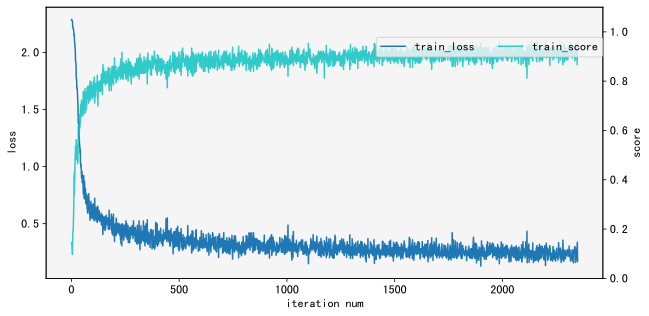

execute time is 72.016 seconds


In [166]:
# define model
model = LeNet5()
model = model.cuda()
# loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# load data
mnist_train, mnist_test = download_data_fashion_mnist()

params = {
    "epoch_num": 10,
    "model": model,
    "loss": loss,
    "data_num": len(mnist_train),
    "optimizer": optimizer,
    "draw": True, 
    "gpu": True,
    "batch_size": 256,
    "evaluate": model.score,   
}

train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8)
params["train_iter"] = train_iter
# params["test_iter"] = test_iter

# training
train_experiment(**params)

### BN简洁实现

In [168]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)
    

class LetNet(nn.Module):
    """带BN的LeNet简洁实现"""
    def __init__(self):
        super(LetNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 120, 5),
            nn.BatchNorm2d(120),
            nn.MaxPool2d(2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )
        
    def forward(self, x):
        output = self.conv(x)
        output = FlattenLayer(output)
        return self.fc(output)
    
    def score(self, x, y):
        y_pred = self.forward(x)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc

Epoch [1/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.8024, train_score: 0.716, test_loss: -, test_score: -

Epoch [2/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3988, train_score: 0.856, test_loss: -, test_score: -

Epoch [3/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3440, train_score: 0.876, test_loss: -, test_score: -

Epoch [4/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3201, train_score: 0.883, test_loss: -, test_score: -

Epoch [5/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2985, train_score: 0.892, test_loss: -, test_score: -

Epoch [6/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2825, train_score: 0.898, test_loss: -, test_score: -

Epoch [7/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2768, train_score: 0.899, test_loss: -, test_score: -

Epoch [8/10]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2606, train_score: 0.90

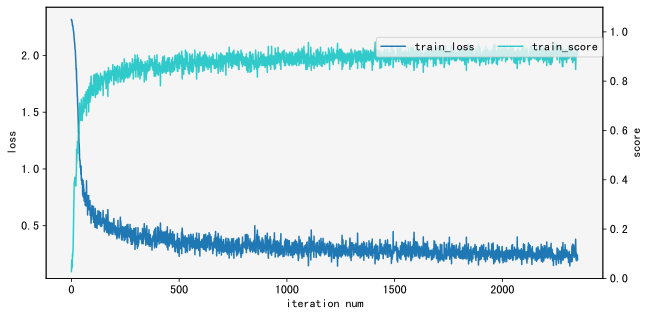

execute time is 72.682 seconds


In [169]:
# define model
model = LeNet5()
model = model.cuda()
# loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# load data
mnist_train, mnist_test = download_data_fashion_mnist()

params = {
    "epoch_num": 10,
    "model": model,
    "loss": loss,
    "data_num": len(mnist_train),
    "optimizer": optimizer,
    "draw": True, 
    "gpu": True,
    "batch_size": 256,
    "evaluate": model.score,   
}

train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8)
params["train_iter"] = train_iter
# params["test_iter"] = test_iter

# training
train_pytorch(**params)